In [56]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy as cvx
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
from tqdm import tqdm
from scipy.stats import gaussian_kde
style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-08-07', cached_dir='../../price_data_utils/cached')
dl.load_data()

Prediction Date: 2019-08-09


In [3]:
data = dl.data
data.head()

,mkt_cap,beta,book_value,sector,eps,month_ago,year_ago,prev_date,analysis_date,trade_date,pred_date,volume
ticker,,,,,,,,,,,,
CSCO,229986631680,0.995519,36804000000,Technology,2.882,56.189999,44.986347,52.599998,52.340000,53.160000,52.430000,24128600.0
SITC,2533060352,0.844472,1499137000,Real Estate,1.043,13.490000,NaN,13.840000,13.780000,14.030000,14.030000,1920086.0
UAL,22748133376,1.223721,10320000000,Industrials,9.838,90.669998,85.220001,85.459999,86.480003,87.629997,86.980003,2380100.0
TROW,26297821184,1.069091,6579100000,Financial Services,7.945,108.959999,112.439903,107.260002,107.040001,110.250000,108.650002,1338400.0
ISRG,61556834304,1.269715,7265300000,Healthcare,10.129,533.159973,525.359985,503.769989,505.359985,519.409973,515.500000,491700.0


In [4]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-09')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [5]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,1990-01-02,17.947027,17.527565,17.557526,17.947027,626200.0,7.267582,KMB
1,1990-01-03,17.976990,17.827181,17.976990,17.887104,749200.0,7.243319,KMB
2,1990-01-04,17.976990,17.797220,17.857143,17.857143,439700.0,7.231189,KMB
3,1990-01-05,17.857143,17.617449,17.797220,17.737297,712500.0,7.182656,KMB
4,1990-01-08,17.917067,17.707335,17.737297,17.917067,495600.0,7.255455,KMB


In [6]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=5)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
new_p = transform_prices(prices, '2016-01-05')


In [7]:
# to make the index of data we have with sector the same as in returns and prices

sector_data = data['sector']
index_ = sector_data.index.intersection(new_p.columns)
sector_data = sector_data.loc[index_]
p = new_p.loc[:, index_].copy() # to use only the stocks that are in sector_data
sectors = sector_data.unique()

In [8]:
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
print(sector_data.shape)
print(p.shape)

(1257, 741)
(741,)
(1258, 741)


In [9]:
p.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,16.319235,25.350000,50.676487,91.209999,692.690002,59.998005,28.536177,40.534866,70.415245,34.523262,...,14.976269,77.790001,17.154980,33.694031,43.528183,23.909542,14.824180,6.94250,151.752335,16.587673
2011-01-06,16.460661,25.750000,50.676487,89.559998,718.400024,62.723892,28.326279,40.797176,69.994743,34.397305,...,14.842355,76.050003,16.839489,33.711502,43.555824,23.958487,14.856651,6.83000,150.116272,16.470205
2011-01-07,16.476372,25.950001,50.264294,89.133331,735.150024,62.590939,28.334854,40.758602,70.200493,34.976746,...,14.686119,75.209999,16.681742,33.589188,43.472923,24.031902,14.669928,6.69375,148.875351,16.315643
2011-01-10,16.334949,26.200001,50.342079,90.526665,749.960022,62.932850,28.647541,41.267784,70.057358,35.111115,...,14.358768,74.680000,16.497704,33.807583,44.891319,24.553984,14.678050,6.90250,151.096298,16.290915
2011-01-11,16.405655,25.690001,50.715374,93.663330,751.900024,63.474232,29.354307,41.653553,72.347855,35.279057,...,14.336452,76.300003,16.333384,33.982292,45.572895,24.456089,14.507563,6.79875,152.874680,16.303284


In [10]:
p.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-29,24.640928,59.299999,66.267441,184.456665,1650.000000,141.577072,48.883698,29.317432,31.023300,45.610756,...,29.112070,136.169998,34.340061,73.815681,75.976669,35.107853,39.816341,41.125000,314.309814,29.093164
2015-12-30,24.427971,57.509998,65.351830,184.169998,1649.540039,140.273254,48.753433,29.024263,29.830099,45.245197,...,28.986509,135.639999,34.271770,73.255249,75.430962,35.071419,39.375340,40.480000,312.891907,29.008694
2015-12-31,24.099659,57.299999,64.807915,182.053329,1643.000000,139.751724,48.278931,29.077566,30.792358,44.842140,...,28.520142,134.580002,34.186417,72.770805,74.725288,34.515739,39.672337,40.305000,311.492279,28.831297
2016-01-04,23.616772,55.610001,63.629417,182.463333,1555.660034,137.626907,48.325451,29.886017,31.100277,44.710915,...,27.910280,130.350006,33.768162,71.944405,73.135201,34.415535,39.096333,39.830002,304.704834,28.451166
2016-01-05,23.509462,55.060001,63.892326,183.986664,1594.089966,137.800766,48.167278,30.179193,31.591042,44.542198,...,28.170368,129.809998,34.382748,71.241478,73.530373,33.559250,39.078335,40.075001,305.491516,28.755270


# Build the risk model with PCA

In [11]:
from sklearn.decomposition import PCA

def fit_pca(returns, num_factors, svd_solver):
    pca = PCA(n_components=num_factors, svd_solver=svd_solver)
    pca.fit(returns)
    return pca
    

In [12]:
num_factors = 20
pca = fit_pca(returns, num_factors, 'full')

pca.components_.shape

(20, 741)

<BarContainer object of 20 artists>

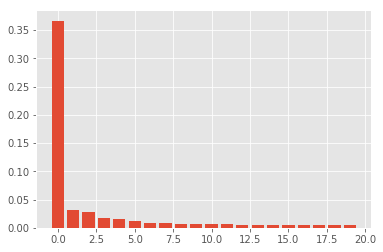

In [13]:
plt.bar(np.arange(num_factors), pca.explained_variance_ratio_)

In [14]:
def get_factor_betas(pca, factor_beta_indices, factor_beta_columns):
    df = pd.DataFrame(data=pca.components_.T, index=factor_beta_indices, columns=factor_beta_columns)
    return df

In [15]:
risk_model = {}
risk_model['factor_betas'] = get_factor_betas(pca, returns.columns, np.arange(num_factors))

risk_model['factor_betas'].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ticker,,,,,,,,,,,,,,,,,,,,
CSCO,-0.030884,-0.010154,-0.015518,-0.008883,0.016165,0.028815,0.003547,0.062729,0.029757,0.013264,-0.003923,-0.008956,0.019916,-0.007801,-0.016465,-0.036984,-0.000072,-0.019233,0.000098,0.007334
UAL,-0.036091,0.056039,-0.084728,-0.046769,0.029784,0.017359,-0.008170,-0.260531,0.142349,0.134276,0.090912,-0.042047,-0.186609,-0.008717,0.045789,-0.088295,-0.033068,0.047201,-0.071520,0.008003
TROW,-0.044288,0.001041,-0.010754,0.022216,0.028145,-0.000257,0.002086,0.017701,0.009538,0.004575,-0.006456,-0.018616,-0.006338,0.016948,-0.006822,-0.000117,-0.012978,-0.027675,-0.008159,0.014549
ISRG,-0.028641,0.014473,-0.012816,-0.022129,-0.017884,-0.001612,0.028411,0.005621,-0.019831,-0.000606,-0.021160,0.012566,0.007453,-0.021764,-0.057191,0.029318,-0.011087,0.011416,-0.037371,-0.007448
NVR,-0.023583,0.011952,-0.021582,0.015904,-0.005907,0.013527,-0.003095,-0.080985,0.021479,-0.069251,-0.026257,0.051536,0.040645,0.039509,-0.046916,-0.042932,0.030923,0.006982,0.038994,-0.023159


In [16]:
def get_factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    return pd.DataFrame(data=pca.transform(returns), index=factor_return_indices, columns=factor_return_columns)

In [17]:
risk_model['factor_returns'] = get_factor_returns(pca, returns, returns.index, np.arange(num_factors))
risk_model['factor_returns'].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2011-01-06,0.081024,0.023784,-0.024381,-0.079254,-0.015238,0.029798,-0.049016,0.006898,0.055988,0.034596,0.008805,0.046749,0.021456,0.034692,-0.016867,0.007676,0.068092,0.029639,-0.047453,-0.018973
2011-01-07,0.044470,0.059705,0.118945,0.008409,-0.066791,0.066051,-0.003572,-0.078740,0.029283,0.038513,0.010774,0.050201,-0.013337,0.045397,0.019300,0.012400,0.024806,0.015167,-0.050798,-0.000657
2011-01-10,-0.076512,0.023343,0.057006,-0.088347,0.006487,0.058343,-0.009756,0.032767,-0.062463,0.026346,-0.000554,-0.009965,-0.053588,-0.010076,0.028088,-0.004149,0.000344,0.012671,0.023259,0.006430
2011-01-11,-0.101920,-0.051234,0.063751,0.007062,0.006599,-0.064718,0.005616,0.054357,0.035877,-0.059382,-0.046724,0.007492,-0.025184,-0.013493,-0.037016,0.023079,0.009514,0.019675,0.051582,-0.062549
2011-01-12,-0.220219,-0.046493,0.001079,-0.001748,0.023253,0.005335,0.006105,-0.001256,0.016743,0.003949,-0.037962,0.027377,0.000150,0.044686,0.024429,0.019628,0.013798,-0.035690,-0.039530,0.027830


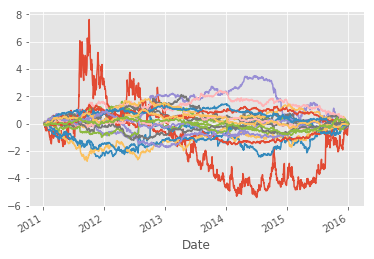

In [18]:
risk_model['factor_returns'].cumsum().plot(legend=None)

In [19]:
def create_factor_cov_matrix(factor_returns, ann_factor):
    var = factor_returns.var(ddof=1)*ann_factor
    return np.diag(var)

In [20]:
ann_factor = 252
risk_model['factor_cov_matrix'] = create_factor_cov_matrix(risk_model['factor_returns'], ann_factor)
#risk_model['factor_cov_matrix']

In [21]:
def create_idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    common_returns = factor_returns.dot(factor_betas.T)
    s = returns - common_returns
    var_s = np.var(s)*ann_factor
    
    return pd.DataFrame(data=np.diag(var_s), index=returns.columns, columns=returns.columns)

In [22]:
risk_model['idiosyncratic_var_matrix'] = create_idiosyncratic_var_matrix(returns, risk_model['factor_returns'],
                                                                         risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix'].head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
ticker,,,,,,,,,,,,,,,,,,,,,
CSCO,0.039024,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UAL,0.000000,0.043439,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TROW,0.000000,0.000000,0.014354,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISRG,0.000000,0.000000,0.000000,0.074505,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NVR,0.000000,0.000000,0.000000,0.000000,0.02745,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
def create_idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    return pd.DataFrame(np.diag(idiosyncratic_var_matrix), idiosyncratic_var_matrix.index)

In [24]:
risk_model['idiosyncratic_var_vector'] = create_idiosyncratic_var_vector(returns, 
                                                                         risk_model['idiosyncratic_var_matrix'])
risk_model['idiosyncratic_var_vector'].head()

,0
ticker,
CSCO,0.039024
UAL,0.043439
TROW,0.014354
ISRG,0.074505
NVR,0.027450


In [25]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    weights = weights.values
    factor_var = np.add(factor_betas.dot(factor_cov_matrix.dot(factor_betas.T)), idiosyncratic_var_matrix)
    result = weights.T.dot(factor_var.dot(weights))
    return result[0][0]

In [26]:
initial_weights = pd.DataFrame(np.repeat(1/len(returns.columns), len(returns.columns)), returns.columns)
print(initial_weights.head())

print(risk_model['factor_betas'].shape)
print(risk_model['factor_cov_matrix'].shape)
print(risk_model['idiosyncratic_var_matrix'].shape)
print(initial_weights.shape)


predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    initial_weights
)

              0
ticker         
CSCO    0.00135
UAL     0.00135
TROW    0.00135
ISRG    0.00135
NVR     0.00135
(741, 20)
(20, 20)
(741, 741)
(741, 1)


0.029995752801006526

In [27]:
def create_momentum_factor(prices, sector_data):

    # demean by sector
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [28]:
momentum = create_momentum_factor(p, sector_data)
print(momentum.shape)
momentum.head()

(1006, 741)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,-0.471847,-1.326777,-0.228916,1.691173,-0.369068,1.588395,1.130563,0.728793,-1.200640,1.032457,...,0.261618,-0.686747,0.149496,-0.158839,-1.051144,1.621097,-1.130563,1.214655,0.126137,-0.172855
2012-01-06,-0.476518,-1.382838,-0.196213,1.686502,-0.583969,1.532334,1.130563,0.752152,-1.256701,1.027785,...,0.355053,-0.551266,0.219572,-0.182198,-1.004426,1.588395,-1.065159,1.275388,0.233587,-0.149496
2012-01-09,-0.513892,-1.448242,-0.294320,1.663143,-0.738136,1.513647,1.172609,0.752152,-1.130563,1.023113,...,0.327022,-0.537251,0.303664,-0.144824,-0.976396,1.588395,-1.027785,1.340792,0.154168,0.070076
2012-01-10,-0.551266,-1.508975,-0.163511,1.649128,-0.896976,1.555693,1.125892,0.569953,-1.191296,1.027785,...,0.415786,-0.560610,0.336366,-0.228916,-1.097861,1.522990,-1.069831,1.261372,0.116794,-0.004672
2012-01-11,-0.527908,-1.457586,-0.303664,1.649128,-0.873617,1.504303,1.083846,0.284977,-1.219327,1.018441,...,0.485862,-0.551266,0.355053,-0.228916,-1.079174,1.518319,-0.995083,1.331449,0.130809,-0.121465


In [29]:
def create_mean_reversion_factor(window_length, prices, sector_data):
    sectors = sector_data.unique()
    df = prices.pct_change(window_length).dropna()
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first', ascending=False)
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [30]:
mean_reversion = create_mean_reversion_factor(5, p, sector_data)
print(mean_reversion.shape)
mean_reversion.head()

(1253, 741)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-12,0.219572,-0.387755,-1.037128,-0.775510,-1.700517,-1.289403,-0.864274,-1.247357,-0.761495,-1.088518,...,1.593067,1.378166,1.602410,-0.406442,-1.471601,-1.233342,0.224244,0.878289,-0.415786,0.766167
2011-01-13,0.481190,0.476518,-1.107205,-1.097861,-1.667815,0.789526,-1.046472,-0.640030,-0.780182,-0.826900,...,1.565036,0.607327,1.443571,0.084091,-1.527662,-1.303418,1.480945,-0.467175,-1.289403,1.574380
2011-01-14,1.041800,1.238014,-1.018441,-1.565036,-1.653799,0.261618,-0.920335,-0.840915,-0.882961,-0.607327,...,1.504303,0.350381,1.336120,-0.504549,-1.681830,-1.401525,1.331449,-1.373494,-1.280059,1.415540
2011-01-18,0.569953,1.644456,-1.060487,-1.593067,-1.597738,1.055815,-1.013770,-0.177526,-1.219327,-0.728793,...,0.588640,-0.429801,0.901648,-0.560610,-1.471601,0.261618,1.200640,-0.976396,-0.107450,1.513647
2011-01-19,0.854930,1.597738,-0.663388,-1.420212,-1.658471,0.560610,0.770839,0.200885,-0.504549,-1.032457,...,-0.070076,0.654045,0.490534,-0.462503,-0.686747,-0.714778,1.177281,-0.953037,0.649373,1.340792


In [31]:
def create_smoothed_factor(factor, window=5):
    df = factor.rolling(window).mean().dropna()
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [32]:
smoothed_mean_reversion = create_smoothed_factor(mean_reversion, 5)
print(smoothed_mean_reversion.shape)
smoothed_mean_reversion.head()

(1249, 741)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-19,0.920335,1.209983,-1.270716,-1.537006,-1.709860,0.411114,-0.878289,-0.784854,-1.149250,-1.181953,...,1.331449,0.724121,1.429555,-0.555938,-1.579051,-1.191296,1.359479,-0.822228,-0.710106,1.551021
2011-01-20,0.948365,1.579051,-1.004426,-1.630441,-1.709860,0.308335,-0.541923,-0.331694,-1.172609,-0.985739,...,0.607327,0.523236,1.312762,-0.233587,-1.499632,-0.962380,1.569708,-0.995083,-0.481190,1.644456
2011-01-21,0.780182,1.672486,-0.616671,-1.677158,-1.625769,-0.476518,0.014015,-0.079420,-1.163266,-1.083846,...,-0.242931,0.205557,1.177281,-0.210229,-1.294075,-0.509221,1.443571,-0.555938,0.116794,1.466929
2011-01-24,0.294320,1.691173,-0.205557,-1.667815,-1.195968,-0.967052,0.509221,0.355053,-1.280059,-1.172609,...,-0.999754,-0.224244,0.967052,0.070076,-1.009098,0.200885,1.144579,0.303664,0.724121,1.195968
2011-01-25,-0.303664,1.635112,0.205557,-1.695845,-0.630686,-1.499632,1.060487,0.602656,-1.270716,-1.312762,...,-1.392181,-0.355053,0.728793,0.420457,-0.925006,0.266290,0.864274,0.948365,0.504549,0.887632


In [33]:
smoothed_momentum = create_smoothed_factor(momentum, window=5)
print(smoothed_momentum.shape)
smoothed_momentum.head()

(1002, 741)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-11,-0.509221,-1.424884,-0.256946,1.667815,-0.696091,1.546349,1.125892,0.621343,-1.200640,1.037128,...,0.369068,-0.560610,0.275633,-0.210229,-1.004426,1.569708,-1.051144,1.298746,0.163511,-0.070076
2012-01-12,-0.518564,-1.443571,-0.270961,1.653799,-0.840915,1.518319,1.144579,0.523236,-1.195968,1.023113,...,0.439144,-0.537251,0.341038,-0.219572,-1.037128,1.560364,-1.023113,1.312762,0.177526,-0.084091
2012-01-13,-0.518564,-1.452914,-0.313007,1.644456,-0.892304,1.518319,1.144579,0.457831,-1.181953,1.018441,...,0.471847,-0.523236,0.341038,-0.205557,-1.088518,1.551021,-1.023113,1.326777,0.140152,-0.018687
2012-01-17,-0.513892,-1.434227,-0.327022,1.644456,-0.957709,1.513647,1.125892,0.411114,-1.191296,0.995083,...,0.527908,-0.485862,0.355053,-0.210229,-1.116548,1.527662,-1.046472,1.317433,0.140152,-0.023359
2012-01-18,-0.485862,-1.420212,-0.350381,1.644456,-0.957709,1.518319,1.130563,0.415786,-1.200640,0.976396,...,0.588640,-0.499877,0.350381,-0.200885,-1.125892,1.541677,-1.046472,1.289403,0.177526,0.014015


In [34]:
index = smoothed_momentum.index.intersection(smoothed_mean_reversion.index)
m = momentum.loc[index,:].stack()
print(m.shape)
sm = smoothed_momentum.loc[index,:].stack()
print(sm.shape)
mr = mean_reversion.loc[index, :].stack()
print(mr.shape)
smr = smoothed_mean_reversion.loc[index, :].stack()
print(smr.shape)
adj_p = p.loc[index,:].copy()
print(adj_p.shape)

(742482,)
(742482,)
(742482,)
(742482,)
(1002, 741)


In [35]:
factor_data = {}
factor_data['momentum'] = al.utils.get_clean_factor_and_forward_returns(m, adj_p, periods=[1])
factor_data['smoothed_momentum'] = al.utils.get_clean_factor_and_forward_returns(sm, adj_p, periods=[1])
factor_data['mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(mr, adj_p, periods=[1])
factor_data['smoothed_mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(smr, adj_p, periods=[1])

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [36]:
factor_data['momentum'].head()

1D    factor  factor_quantile
date       asset                                     
2012-01-11 CSCO   0.004195 -0.527908                2
           UAL    0.028873 -1.457586                1
           TROW   0.000674 -0.303664                3
           ISRG   0.002582  1.649128                5
           NVR    0.000000 -0.873617                2

In [37]:
factor_returns_df = pd.DataFrame()
for key, val in factor_data.items():
    factor_returns_df[key] = al.performance.factor_returns(val).iloc[:,0]
factor_returns_df.head()

,smoothed_mean_reversion,mean_reversion,smoothed_momentum,momentum
date,,,,
2012-01-11,-0.000653,-0.001573,-0.001546,-0.001369
2012-01-12,0.000639,0.000580,0.003501,0.003533
2012-01-13,0.001002,0.000827,0.001819,0.001780
2012-01-17,-0.001951,-0.000152,-0.005174,-0.005238
2012-01-18,-0.000471,-0.000772,-0.004836,-0.004848


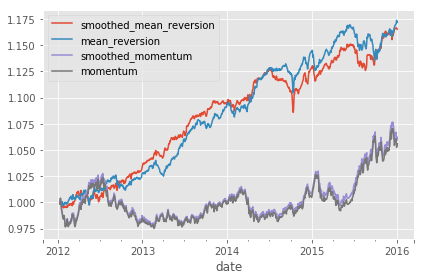

In [38]:
(1+factor_returns_df).cumprod().plot()
plt.tight_layout()

# Quantile Analysis

In [39]:
factor_names = factor_data.keys()
factor_names

dict_keys(['smoothed_mean_reversion', 'mean_reversion', 'smoothed_momentum', 'momentum'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1216ae160>,
      dtype=object)

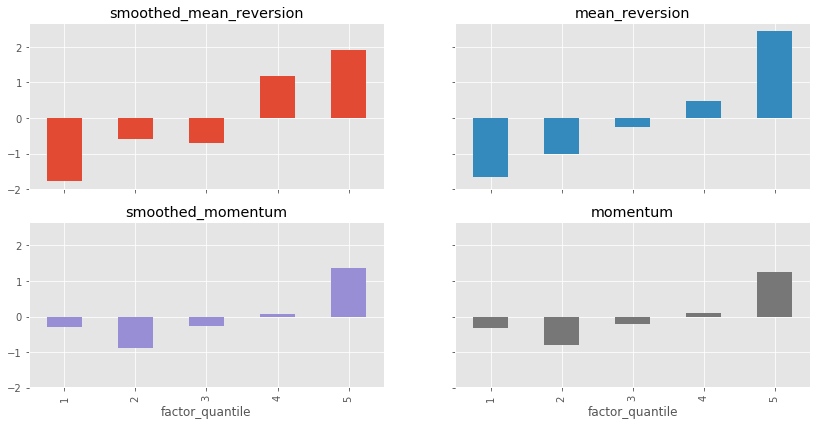

In [40]:
qr_factor_returns = pd.DataFrame()
for key, val in factor_data.items():
    qr_factor_returns[key] = al.performance.mean_return_by_quantile(val)[0].iloc[:,0]


(10000 * qr_factor_returns).plot.bar(
    subplots=True,
    sharey = True,
    layout=(4,2),
    figsize=(14,14),
    legend=False
)

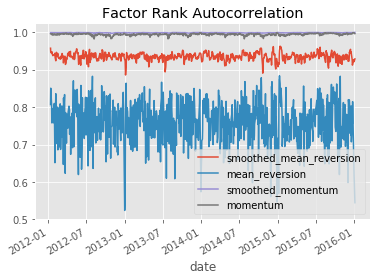

In [41]:
# Turnover analysis

fra_df = pd.DataFrame()

for key, val in factor_data.items():
    fra_df[key] = al.performance.factor_rank_autocorrelation(val)
    
fra_df.plot(title='Factor Rank Autocorrelation')

## sharpe ratio of the alphas

In [42]:
def get_sharpe_ratio(factor_returns, ann_factor):
    sharpe = factor_returns.mean() / (factor_returns.std())
    return sharpe * ann_factor

In [43]:
ann_factor = np.sqrt(252)
get_sharpe_ratio(factor_returns_df, ann_factor).round(2)

smoothed_mean_reversion    1.82
mean_reversion             1.87
smoothed_momentum          0.49
momentum                   0.44
dtype: float64

# The combined alpha vector

In [44]:
all_factors_df = pd.DataFrame()
for key, val in factor_data.items():
    all_factors_df[key] = val.loc[:,'factor']
all_factors_df.head()

smoothed_mean_reversion  mean_reversion  smoothed_momentum  \
date       asset                                                               
2012-01-11 CSCO                 -0.350381        1.312762          -0.509221   
           UAL                   1.677158        1.579051          -1.424884   
           TROW                 -0.270961       -0.037374          -0.256946   
           ISRG                  1.284731        1.607082           1.667815   
           NVR                  -0.429801        0.401770          -0.696091   

                  momentum  
date       asset            
2012-01-11 CSCO  -0.527908  
           UAL   -1.457586  
           TROW  -0.303664  
           ISRG   1.649128  
           NVR   -0.873617

In [45]:
selected_factors = ['smoothed_mean_reversion', 'mean_reversion']
all_factors_df['alpha_vector'] = all_factors_df[selected_factors].mean(axis=1)
alphas = all_factors_df[['alpha_vector']]
alpha_vector = alphas.loc[all_factors_df.index.get_level_values(0)[-1]]
alpha_vector.head()

,alpha_vector
asset,
CSCO,-0.763831
UAL,1.515983
TROW,-0.079420
ISRG,-0.906319
NVR,1.621097


# Optimal Portfolio Constrained by Risk Model

In [46]:
from abc import ABC, abstractmethod

In [47]:

class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=1000)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

In [48]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        av = -alpha_vector
        return cvx.Minimize(np.array(av.T) @ weights)
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function=
        
        return [risk <= self.risk_cap**2, factor_betas.T @ weights <= self.factor_max, factor_betas.T @ weights >= self.factor_min, \
                sum(weights) == 0, sum(cvx.abs(weights)) <= 1, weights >= self.weights_min, weights <= self.weights_max]

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

In [49]:
print(risk_model.keys())
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], 
                                         risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

dict_keys(['idiosyncratic_var_vector', 'idiosyncratic_var_matrix', 'factor_returns', 'factor_cov_matrix', 'factor_betas'])


/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


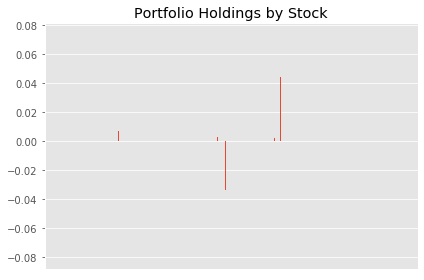

In [50]:
optimal_weights.plot.bar(legend=None, title='Portfolio Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.rcParams['figure.figsize'] = (14,14)
plt.tight_layout()

# Optimize with a Regularization Parameter

In [51]:
class OptimalHoldingsReg(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        assert(len(alpha_vector.columns)==1)
        return cvx.Maximize(np.array(alpha_vector.T) @ weights - self.lambda_reg * cvx.norm(weights, 2))
    
    def __init__(self, lambda_reg=0.50, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55,
                 weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

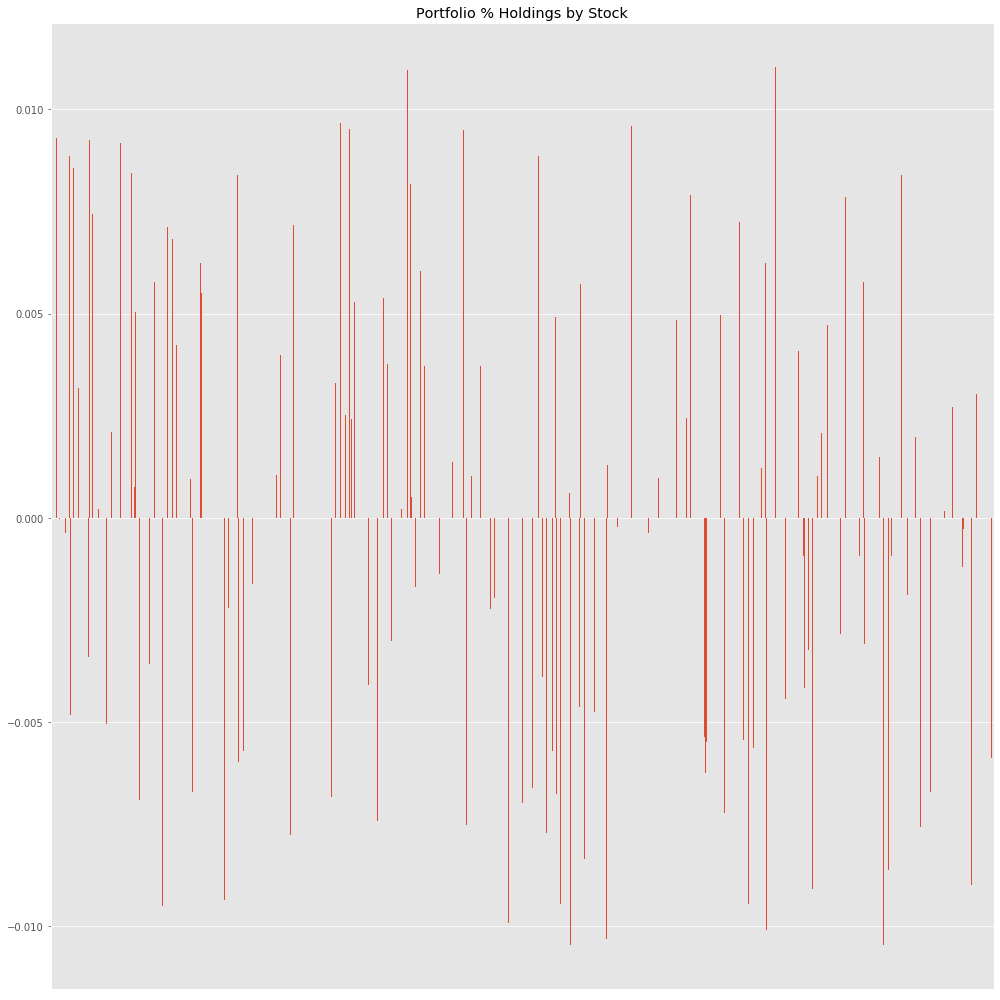

In [52]:
optimal_weights_1 = OptimalHoldingsReg(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.rcParams['figure.figsize'] = (14,14)
plt.tight_layout()

# Backtesting

In [55]:
num_factors = 20
def create_factor_data(returns, num_factors):
    ann_factor = 252
    index = returns.loc[returns.index.year==2015].index
    data = {}
    betas = {}
    facrets = {}
    covmats = {}
    for d in tqdm(index):
        ix = d.strftime('%Y%m%d')
        year_ago = d - dt.timedelta(days=365)
        yest = d - dt.timedelta(days=1)
        rets_df = returns.loc[year_ago:yest,:]
        pca = fit_pca(rets_df, num_factors, 'full')
        factor_exposures = get_factor_betas(pca, rets_df.columns, np.arange(num_factors))
        betas[ix] = factor_exposures
        
        factor_exposures['DataDate'] = yest
        factor_exposures['DlyReturn'] = returns.loc[d, factor_exposures.index].T
        factor_exposures['DlyReturnDate'] = d
        data[ix] = factor_exposures
        
        facret = get_factor_returns(pca, rets_df, rets_df.index, np.arange(num_factors))
        facrets[ix] = facret
        
        covmat = create_factor_cov_matrix(facret, ann_factor)
        covmats[ix] = covmat
    
    return data, betas, facrets, covmats


data, betas, facrets, covmats = create_factor_data(returns, num_factors) 
print(facrets['20150102'].head())
print(covmats['20150102'])

100%|██████████| 252/252 [00:11<00:00, 21.71it/s]

                  0         1         2         3         4         5   \
Date                                                                     
2014-01-02  0.244638  0.044537  0.100843 -0.047071  0.011002  0.010196   
2014-01-03 -0.034791  0.033202 -0.031641 -0.025669  0.011681  0.003026   
2014-01-06  0.140752  0.004111  0.018924  0.065412 -0.001523 -0.110570   
2014-01-07 -0.270137  0.159733  0.313621  0.420304  0.692009  0.180796   
2014-01-08 -0.064139  0.053643  0.067884 -0.080881 -0.055256  0.034353   

                  6         7         8         9         10        11  \
Date                                                                     
2014-01-02 -0.077780 -0.026846  0.058321  0.006974  0.000422 -0.032032   
2014-01-03  0.052254 -0.028851  0.009078 -0.051969  0.021530 -0.032351   
2014-01-06 -0.058212  0.010148 -0.032233 -0.038098  0.054024  0.024816   
2014-01-07 -0.010299 -0.138184 -0.082557  0.076831  0.025218  0.019013   
2014-01-08 -0.081409  0.014925 -0.065

In [57]:
def density_plot(data):
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data), np.max(data), 200)
    density.covariance_factor = lambda: 0.25
    density._compute_covariance()
    plt.plot(xs, density(xs))
    plt.show()


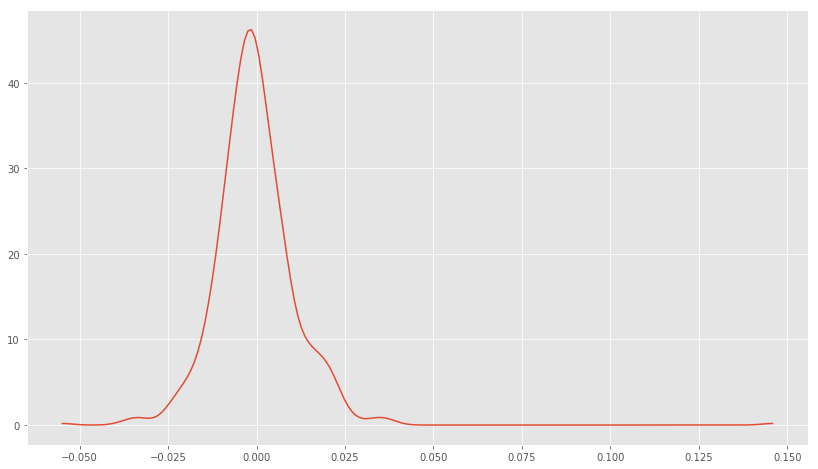

In [58]:
test = data['20150102']
density_plot(test['DlyReturn'])

In [59]:
def winz(x, wins_lower, wins_upper):
    clipped_upper = np.where(x >= wins_upper, wins_upper, x)
    clipped_both = np.where(clipped_upper <= wins_lower, wins_lower, x)
    return clipped_both

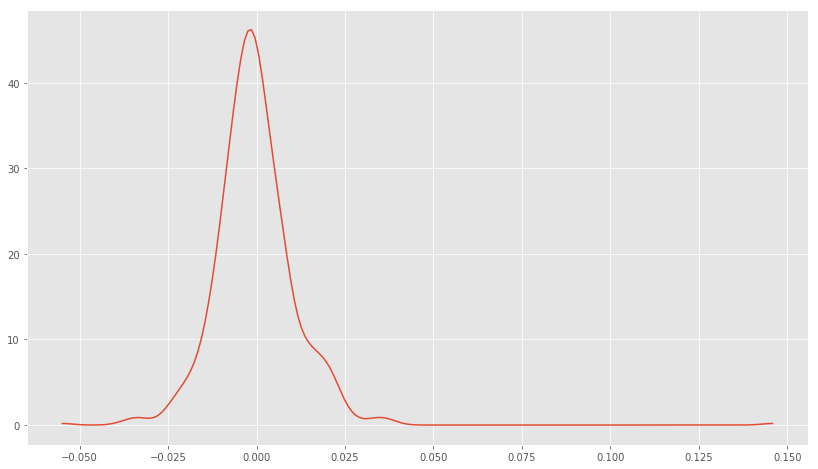

In [62]:
test['DlyReturn_winz'] = winz(test['DlyReturn'], wins_lower=-0.1, wins_upper=0.1)
density_plot(test['DlyReturn_winz'])

In [64]:
facrets['20150102'].tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2014-12-24,-0.009855,0.094107,0.025767,0.018353,-0.054463,0.022877,0.003463,0.019713,-0.015544,0.001494,-0.000137,-0.011509,0.026597,0.003140,0.033655,0.011641,-0.031285,-0.018979,-0.001092,0.001149
2014-12-26,-0.084508,0.050152,0.080242,0.076372,-0.002447,-0.016679,-0.034459,0.033079,0.010415,0.001049,-0.001647,-0.024540,-0.000378,0.023271,0.033629,0.013684,-0.012636,0.001632,0.012823,0.012651
2014-12-29,-0.065742,-0.026578,-0.003444,0.030536,-0.041648,-0.012739,0.017690,0.009065,0.071336,-0.009988,0.035975,-0.028090,0.018318,0.039034,0.035046,-0.009266,-0.033899,-0.006531,0.004601,0.012598
2014-12-30,0.139114,0.012596,-0.007326,-0.069525,0.024252,-0.010453,0.001916,-0.030005,-0.009854,0.021795,0.028802,-0.039910,-0.024274,-0.000832,-0.019472,0.057957,0.032233,0.029447,-0.011805,-0.022680
2014-12-31,0.223027,-0.022625,0.113558,-0.118541,0.032096,-0.031739,-0.090975,-0.049863,0.012518,-0.018114,0.030249,-0.007379,-0.012830,0.010142,-0.030927,-0.007935,-0.016719,0.006838,-0.014292,0.009022
